Используя датасет "Пассажиры автобуса", создайте нейронную сеть для решения задачи классификации пассажиров на входящих и выходящих.

Добейтесь точности работы модели выше 90% на проверочной выборке

### Загрузка данных


In [1]:
# загрузка библиотек

# методы для отрисовки изображений
from PIL import Image

# Для отрисовки графиков
import matplotlib.pyplot as plt

# Для генерации случайных чисел
import random

# Библиотека работы с массивами
import numpy as np

# Для работы с файлами
import os

# импортируем модуль для загрузки данных
import gdown

# для разделения выборок
from sklearn.model_selection import train_test_split

# для создания сети
from tensorflow.keras.models import Sequential

# для создания слоев
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

# для работы с изображениями
from tensorflow.keras.preprocessing import image

# оптимизатор
from tensorflow.keras.optimizers import Adam

# модуль для отсчета времени
import time

import zipfile

In [3]:
# загрузка датасета, укажем путь к базе в Google Drive, база в виде .zip-архива
# https://storage.yandexcloud.net/algorithmic-datasets/bus.zip
gdown.download('https://storage.yandexcloud.net/algorithmic-datasets/bus.zip', 'data/bus.zip', quiet=True)

with zipfile.ZipFile('data/bus.zip', 'r') as zip_ref:
    zip_ref.extractall('data/bus')
    zip_ref.close()

# Папка с папками картинок, рассортированных по категориям
IMAGE_PATH = 'data/bus/'

# Получение списка папок, находящемуся по адресу в скобках
os.listdir(IMAGE_PATH)

['Выходящий', 'Входящий']

In [4]:
# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 2, метки классов: ['Входящий', 'Выходящий']


In [5]:
# Получения списка файлов для каждого класса

for cls in CLASS_LIST:
    print(cls, ':', os.listdir(f'{IMAGE_PATH}{cls}/'))

Входящий : ['02758.jpg', '00761.jpg', '04363.jpg', '03942.jpg', '06369.jpg', '00713.jpg', '03344.jpg', '05502.jpg', '02627.jpg', '02897.jpg', '06210.jpg', '06379.jpg', '04288.jpg', '04595.jpg', '04739.jpg', '06214.jpg', '03836.jpg', '00064.jpg', '00077.jpg', '02560.jpg', '06427.jpg', '02077.jpg', '01438.jpg', '04906.jpg', '03749.jpg', '00312.jpg', '01968.jpg', '02140.jpg', '01902.jpg', '04872.jpg', '04837.jpg', '05048.jpg', '03295.jpg', '04143.jpg', '03184.jpg', '01696.jpg', '04821.jpg', '04704.jpg', '03016.jpg', '00672.jpg', '00577.jpg', '00352.jpg', '06483.jpg', '03504.jpg', '02856.jpg', '04889.jpg', '00277.jpg', '03800.jpg', '03485.jpg', '06358.jpg', '04805.jpg', '05643.jpg', '04449.jpg', '01954.jpg', '06465.jpg', '05890.jpg', '05808.jpg', '00866.jpg', '02794.jpg', '02696.jpg', '06373.jpg', '01544.jpg', '00140.jpg', '02594.jpg', '01945.jpg', '05251.jpg', '05444.jpg', '04894.jpg', '05798.jpg', '04680.jpg', '04548.jpg', '06068.jpg', '01198.jpg', '05441.jpg', '03018.jpg', '05925.jpg', 

Отобразим визуально для примера по одному изображению из каждого класса (при помощи функции `.imshow()` из модуля `matplotlib.pyplot`):

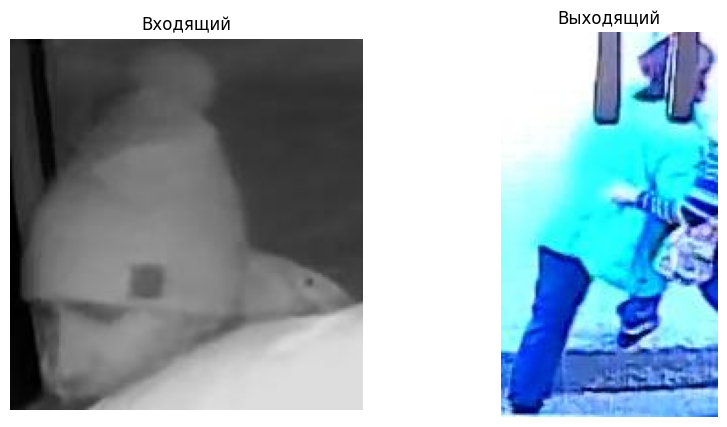

In [6]:
# Создание заготовки для изображений всех классов
fig, axs = plt.subplots(1, CLASS_COUNT, figsize=(10, 5))

# Для всех номеров классов:
for i in range(CLASS_COUNT):

    # Формирование пути к папке содержимого класса
    car_path = f'{IMAGE_PATH}{CLASS_LIST[i]}/'

    # Выбор случайного фото из i-го класса
    img_path = car_path + random.choice(os.listdir(car_path))

    # Отображение фотографии (подробнее будет объяснено далее)
    axs[i].set_title(CLASS_LIST[i])
    axs[i].imshow(Image.open(img_path))
    axs[i].axis('off')

# Отрисовка всего полотна
plt.show()

In [7]:
data_files = []                           # Cписок путей к файлам картинок
data_labels = []                          # Список меток классов, соответствующих файлам

for class_label in range(CLASS_COUNT):    # Для всех классов по порядку номеров (их меток)
    class_name = CLASS_LIST[class_label]  # Выборка имени класса из списка имен
    class_path = IMAGE_PATH + class_name  # Формирование полного пути к папке с изображениями класса
    class_files = os.listdir(class_path)  # Получение списка имен файлов с изображениями текущего класса
    print(f'Размер класса {class_name} составляет {len(class_files)} фото')

    # Добавление к общему списку всех файлов класса с добавлением родительского пути
    data_files += [f'{class_path}/{file_name}' for file_name in class_files]

    # Добавление к общему списку меток текущего класса - их ровно столько, сколько файлов в классе
    data_labels += [class_label] * len(class_files)

print()
print('Общий размер базы для обучения:', len(data_labels))

Размер класса Входящий составляет 6485 фото
Размер класса Выходящий составляет 2596 фото

Общий размер базы для обучения: 9081


In [9]:
# Разделение выборки на обучающую и тестовую
train_files, test_files, train_labels, test_labels = train_test_split(data_files, data_labels, test_size=0.2, random_state=42)

# Разделение обучающей выборки на обучающую и валидационную
train_files, valid_files, train_labels, valid_labels = train_test_split(train_files, train_labels, test_size=0.2, random_state=42)

# Проверка результатов
print('Размер обучающей выборки:', len(train_labels))
print('Размер валидационной выборки:', len(valid_labels))
print('Размер тестовой выборки:', len(test_labels))

# Функция для загрузки изображения и его преобразования в массив
def load_image(file_path):
    img = image.load_img(file_path, target_size=(150, 150))  # Загрузка изображения и изменение его размера
    img = image.img_to_array(img)                          # Преобразование изображения в массив
    img = img / 255.0                                       # Нормализация значений пикселей
    return img

# Функция для генерации пакета изображений и их меток
def batch_generator(files, labels, batch_size):
    while True:
        # Перемешивание индексов
        indexes = np.random.permutation(len(labels))

        # Цикл по пакетам
        for ind in range(0, len(indexes), batch_size):
            batch_indexes = indexes[ind:ind + batch_size]  # Получение индексов очередного пакета
            batch_files = [files[i] for i in batch_indexes]  # Получение файлов очередного пакета
            batch_labels = [labels[i] for i in batch_indexes]  # Получение меток очередного пакета

            # Преобразование изображений и меток в массивы
            batch_images = np.array([load_image(file_name) for file_name in batch_files])
            batch_labels = np.array(batch_labels)

            yield batch_images, batch_labels  # Возврат пакета

# Создание генераторов пакетов
train_generator = batch_generator(train_files, train_labels, 32)
valid_generator = batch_generator(valid_files, valid_labels, 32)
test_generator = batch_generator(test_files, test_labels, 32)


Размер обучающей выборки: 5811
Размер валидационной выборки: 1453
Размер тестовой выборки: 1817


In [11]:
# Создание модели
model = Sequential()

# Добавление сверточного слоя
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))

# Добавление слоя пулинга
model.add(MaxPooling2D((2, 2)))

# Добавление сверточного слоя
model.add(Conv2D(64, (3, 3), activation='relu'))

# Добавление слоя пулинга
model.add(MaxPooling2D((2, 2)))

# Добавление сверточного слоя
model.add(Conv2D(128, (3, 3), activation='relu'))

# Добавление слоя пулинга
model.add(MaxPooling2D((2, 2)))

# Преобразование двумерного массива в одномерный
model.add(Flatten())

# Добавление полносвязного слоя
model.add(Dense(512, activation='relu'))

# Добавление слоя регуляризации
model.add(Dropout(0.5))

# Добавление выходного слоя
model.add(Dense(CLASS_COUNT, activation='softmax'))

# Компиляция модели
model.compile(optimizer=Adam(lr=0.0001), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

display(model.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 17, 17, 128)      

None

Epoch 1/10
181/181 [==============================] - 18s 55ms/step - loss: 0.4740 - accuracy: 0.7837 - val_loss: 0.3375 - val_accuracy: 0.8271
Epoch 2/10
181/181 [==============================] - 11s 59ms/step - loss: 0.3175 - accuracy: 0.8659 - val_loss: 0.2791 - val_accuracy: 0.8903
Epoch 3/10
181/181 [==============================] - 10s 57ms/step - loss: 0.1983 - accuracy: 0.9140 - val_loss: 0.1913 - val_accuracy: 0.9264
Epoch 4/10
181/181 [==============================] - 9s 52ms/step - loss: 0.1348 - accuracy: 0.9450 - val_loss: 0.1569 - val_accuracy: 0.9299
Epoch 5/10
181/181 [==============================] - 10s 56ms/step - loss: 0.0949 - accuracy: 0.9616 - val_loss: 0.1365 - val_accuracy: 0.9514
Epoch 6/10
181/181 [==============================] - 11s 62ms/step - loss: 0.0625 - accuracy: 0.9777 - val_loss: 0.1095 - val_accuracy: 0.9660
Epoch 7/10
181/181 [==============================] - 10s 54ms/step - loss: 0.0359 - accuracy: 0.9881 - val_loss: 0.1678 - val_accuracy: 

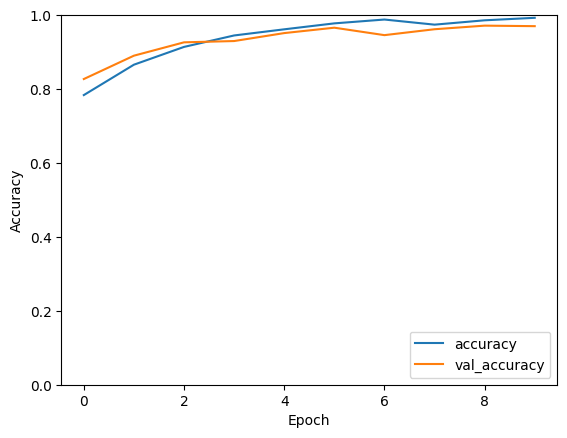

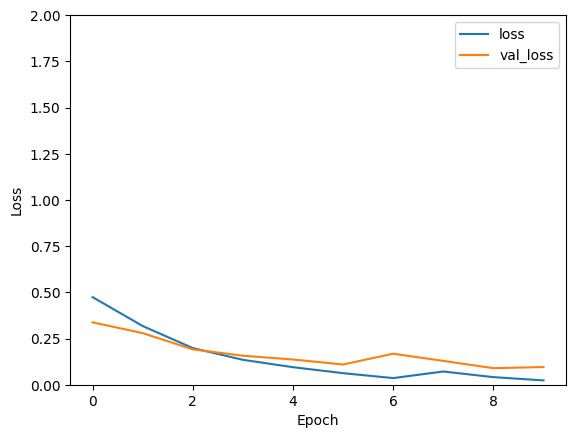

56/56 [==============================] - 2s 36ms/step - loss: 0.1057 - accuracy: 0.9682


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
# Обучение модели
history = model.fit(train_generator, steps_per_epoch=len(train_labels) // 32,
                    epochs=10, validation_data=valid_generator,
                    validation_steps=len(valid_labels) // 32)

# Отображение графика точности обучения
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Отображение графика функции потерь
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend(loc='upper right')
plt.show()

# Оценка качества модели
model.evaluate(test_generator, steps=len(test_labels) // 32)

# Сохранение модели
model.save('bus_model.keras')
